# Schwinger bosons for two coupled spins

In [1]:
using FFTW, Interpolations
using KadanoffBaym
using LinearAlgebra
using UnPack
using ProgressMeter

using PyPlot
using PyCall
qt = pyimport("qutip")
np = pyimport("numpy")

font_size = 16
# font_size = 20

PyPlot.matplotlib.rc("text", usetex=true)
PyPlot.matplotlib.rc("font", family="serif", size=font_size)
PyPlot.matplotlib.rc("axes", labelsize=font_size)
PyPlot.matplotlib.rc("xtick.major", size=8)
PyPlot.matplotlib.rc("ytick.major", size=8)
PyPlot.matplotlib.rc("xtick.minor", visible=true, size=4)
PyPlot.matplotlib.rc("ytick.minor", visible=true, size=4)
PyPlot.matplotlib.rc("xtick", top=true, direction="inout")
PyPlot.matplotlib.rc("ytick", right=true, direction="inout")

### Hamiltonian

\begin{align}
    H &=  h \sum_{i=1, 2} \left(a^\dagger_{i} a^{\phantom{\dagger}}_{i} - b^\dagger_{i} b^{\phantom{\dagger}}_{i} \right) + J \left( a^\dagger_{1}b^{\phantom{\dagger}}_{1} b^\dagger_{2} a^{\phantom{\dagger}}_{2} + \mathrm{h.c.}\right) 
\end{align}

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.98.224304

## KadanoffBaym.jl

In [2]:
function integrate(x::AbstractVector, y::AbstractVector)
    if isone(length(x))
        return zero(first(y))
    end

    @inbounds retval = (x[2] - x[1]) * (y[1] + y[2])
    @inbounds @fastmath @simd for i in 2:(length(y) - 1)
        retval += (x[i+1] - x[i]) * (y[i] + y[i+1])
    end
    return 1//2 * retval
end;

In [3]:
# NOTE: not type-stable

# Container for problem data
struct Problem
    GL::GreenFunction{ComplexF64, Array{ComplexF64, 4}, Lesser}
    GG::GreenFunction{ComplexF64, Array{ComplexF64, 4}, Greater}
    ΣL::GreenFunction{ComplexF64, Array{ComplexF64, 4}, Lesser}
    ΣG::GreenFunction{ComplexF64, Array{ComplexF64, 4}, Greater}
    L::Int64
    H::Matrix{ComplexF64}
    J::Float64
  
    # Initialize problem
    function Problem(GL0::Matrix{ComplexF64}, L::Int64, H::Matrix{ComplexF64}, J::Float64)
        @assert H == H' "A complex Hamiltonian requires revision of the equations"

        problem = new(
          GreenFunction(reshape(GL0, size(GL0)..., 1, 1), Lesser),
          GreenFunction(reshape(GL0 - 1.0im * I, size(GL0)..., 1, 1), Greater),
          GreenFunction(zeros(ComplexF64, size(GL0)..., 1, 1), Lesser),
          GreenFunction(zeros(ComplexF64, size(GL0)..., 1, 1), Greater),
          L,
          H,
          J
        )

        # Initialize self-energies
        self_energies!(problem, 1, 1)

        return problem
    end
end

In [4]:
# Vertical rhs
function f_vert(problem, times, t1, t2)
  @unpack GL, GG, ΣL, ΣG, L, H = problem
  
  # real-time collision integral
  ∫dt(i, j, A, B) = sign(j-i) * integrate(times[min(i, j):max(i, j)], 
    [A[t1, t] .* B[t, t2] for t=min(i, j):max(i, j)])

  dGL = -1.0im * (H * GL[t1, t2] + ∫dt(1, t1, ΣG, GL) - ∫dt(1, t1, ΣL, GL) + ∫dt(1, t2, ΣL, GL) - ∫dt(1, t2, ΣL, GG))
  dGG = -1.0im * (H * GG[t1, t2] + ∫dt(1, t1, ΣG, GG) - ∫dt(1, t1, ΣL, GG) + ∫dt(1, t2, ΣG, GL) - ∫dt(1, t2, ΣG, GG))
  return [dGL, dGG] .|> (diagm ∘ diag)
end

# Diagonal rhs
function f_diag(problem, times, t1)
  @unpack GL, GG, ΣL, ΣG, L, H = problem
  
  # commutator
  ⋊(a, b) = a * b - b * a
  
  # real-time collision integral
  ∫dt(A, B) = integrate(times, [A[t1, t] .* B[t, t1] for t=1:t1])

  I = ∫dt(ΣG, GL) - ∫dt(ΣL, GG) + ∫dt(GL, ΣG) - ∫dt(GG, ΣL)
  
  dGL = -1.0im * (H ⋊ GL[t1, t1] + I)
  dGG = -1.0im * (H ⋊ GG[t1, t1] + I)
  return [dGL, dGG] .|> (diagm ∘ diag)
end

# Self-energy
function self_energies!(problem, t1, t2)
    @unpack GL, GG, ΣL, ΣG, L, H, J = problem

    if (n = size(GL, 3)) > size(ΣL, 3)
    resize!(ΣL, n)
    resize!(ΣG, n)
    end
  
    NNs = [1, 0] # nearest neighbours
    N_mu = mu -> NNs[mu % L + 1] + mu - mu % L
    idxs = [[(mu + L) % 2L, N_mu(mu), (N_mu(mu) + L) % 2L] .+ 1 for mu in 0:2L-1]
    idxs = hcat(idxs...)
    
    ΣL[t1, t2] = -J^2 * GL[t1, t2][idxs[1, :], idxs[1, :]] .* GL[t1, t2][idxs[2, :], idxs[2, :]] .* GG[t2, t1][idxs[3, :], idxs[3, :]] |> (diagm ∘ diag)
    ΣG[t1, t2] = -J^2 * GG[t1, t2][idxs[1, :], idxs[1, :]] .* GG[t1, t2][idxs[2, :], idxs[2, :]] .* GL[t2, t1][idxs[3, :], idxs[3, :]] |> (diagm ∘ diag)
    
end

# Integration boundaries
tspan = (0.0, 5.0)

# Problem data
problem = begin

    # Parameters
    L = 2
    h = 5.0
    H = ComplexF64[-h 0 0 0; 0 -h 0 0; 0 0 h 0; 0 0 0 h];
    J = 0*1.

    # Initial condition
    delta_n = 0.1
#     GL0 = -1.0im * [0.5 + delta_n 0 0 0; 0 0.5 0 0; 0 0 0.5 - delta_n 0; 0 0 0 0.5]
    GL0 = -1.0im .* 2e-1 .* [2 0 0 0; 0 1 0 0; 0 0 2 0; 0 0 0 0.5]

    Problem(GL0, L, H, J)
end

# Integration
sol = kbsolve(
  (u, x...) -> f_vert(problem, x...), 
  (u, x...) -> (println(" t: $(x[1][x[2]])"); f_diag(problem, x...)), 
  [problem.GL, problem.GG], 
  (tspan[1], 
  tspan[2]); 
  update_time = (_, x...) -> self_energies!(problem, x...), 
  atol=1e-5, 
  rtol=1e-3, 
  dtini=1e-5,
  dtmax=5e-2);

 t: 0.0
 t: 2.0000000000000003e-6
 t: 2.0000000000000003e-6
 t: 1.2e-5
 t: 1.2e-5
 t: 6.199999999999999e-5
 t: 6.199999999999999e-5
 t: 0.00031199999999999994
 t: 0.00031199999999999994
 t: 0.0015619999999999996
 t: 0.0015619999999999996
 t: 0.0026869999999999993
 t: 0.0026869999999999993
 t: 0.008311999999999996
 t: 0.008311999999999996
 t: 0.03643699999999998
 t: 0.03643699999999998
 t: 0.06174949999999997
 t: 0.06174949999999997
 t: 0.11174949999999997
 t: 0.11174949999999997
 t: 0.1617495
 t: 0.1617495
 t: 0.2067495
 t: 0.2067495
 t: 0.2567495
 t: 0.2567495
 t: 0.3067495
 t: 0.3067495
 t: 0.3517495
 t: 0.3517495
 t: 0.4017495
 t: 0.4017495
 t: 0.45174949999999997
 t: 0.45174949999999997
 t: 0.5017495
 t: 0.5017495
 t: 0.5517495
 t: 0.5517495
 t: 0.6017495
 t: 0.6017495
 t: 0.6517495000000001
 t: 0.6517495000000001
 t: 0.7017495000000001
 t: 0.7017495000000001
 t: 0.7467495000000002
 t: 0.7467495000000002
 t: 0.7967495000000002
 t: 0.7967495000000002
 t: 0.8467495000000003
 t: 0.846

In [5]:
state = sol;

## QuTiP benchmark

In [6]:
# time parameters
times = range(first(sol.t), stop=last(sol.t), length=length(sol.t)) # range(tspan[1]; stop=tspan[2], length=length(state.t));
n = length(state.t) - 1

109

### Schwinger-Boson Hamiltonian

In [7]:
n_max = 2; # Fock-space truncation

# psi0_list = [qt.basis(n_max + 1, 1),
#              qt.basis(n_max + 1, 0),
#              qt.basis(n_max + 1, 0),
#              qt.basis(n_max + 1, 1)]

psi0_list = [(sqrt(1 - 1.0im * problem.GL[1, 1][k, k]) * qt.basis(n_max + 1, 0) 
        + sqrt(1.0im * problem.GL[1, 1][k, k]) * qt.basis(n_max + 1, 1)).unit() for k in 1:2*L]

psi0 = qt.tensor(psi0_list);

# operators

id_list = [qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1)]

b1_list = [qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1)] # cp.aepcopy(id_list)
b1_list[1] = qt.destroy(n_max + 1)
b1 = qt.tensor(b1_list)

b2_list = [qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1)] # cp.aepcopy(id_list)
b2_list[2] = qt.destroy(n_max + 1)
b2 = qt.tensor(b2_list)

a1_list = [qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1)] # cp.aepcopy(id_list)
a1_list[3] = qt.destroy(n_max + 1)
a1 = qt.tensor(a1_list)

a2_list = [qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1), qt.qeye(n_max + 1)] # cp.aepcopy(id_list)
a2_list[4] = qt.destroy(n_max + 1)
a2 = qt.tensor(a2_list);

In [8]:
# stupid hack because this
# rho0 = qt.Qobj((psi0 * psi0.dag()).diag() |> diagm |> PyObject, type="oper", dims=b1.dims)
# does not work...
rho0 = psi0 * psi0.dag();
for i in 1:rho0.shape[1], j in 1:rho0.shape[2] 
    if i != j
        rho0.data[i, j] = 0.0
    end
end

In [9]:
H  = -h * b1.dag() * b1
H += -h * b2.dag() * b2
H += +h * a1.dag() * a1
H += +h * a2.dag() * a2
H += J * (a1.dag() * b1 * b2.dag() * a2 + b1.dag() * a1 * a2.dag() * b2)

# observables
obs = [b1.dag() * b1, b2.dag() * b2, a1.dag() * a1, a2.dag() * a2,
       b1.dag() * a1, b2.dag() * a2, b2.dag() * a1, a2.dag() * b1,
       b1 * b1.dag()];

### Simulation

In [10]:
# quickly solve once for observables
# me = qt.mesolve(H, psi0, times, [], obs)
me = qt.mesolve(H, rho0, times, [], obs)

# solve for the time-apenant ansity matrix
# t_sols = qt.mesolve(H, psi0, times); # t_sols.states returns state vectors
t_sols = qt.mesolve(H, rho0, times); # t_sols.states returns density matrices

#### Two times

In [563]:
# destroy = sigma1_m 
# create = sigma1_m.dag(); 

destroy = b1;
create = b1.dag();

In [11]:
create_destroy = [zeros(ComplexF64, n + 1, n + 1) for _ in 1:2L]
destroy_create = [zeros(ComplexF64, n + 1, n + 1) for _ in 1:2L];

In [12]:
# <X(t2 > t1)Y(t1)>
function two_time_average(X, Y)
    X_t2_Y_t1 = zeros(ComplexF64, n + 1, n + 1)
    @showprogress 1 for k in 1:(n + 1)
        Y_rho_t1 = qt.mesolve(H, Y * t_sols.states[k], times).states
        for l in 1:(n + 1)
            X_t2_Y_t1[k, l] = -1.0im * (X * Y_rho_t1[l]).tr()    
        end
    end
    
    unskewed_X_t2_Y_t1 = zeros(ComplexF64, n + 1, 2*(n + 1) - 1)
    for (k, x) in enumerate([X_t2_Y_t1[k, :] for k in 1:(n + 1)])
        for (l, y) in enumerate(x)
            ind = k + l - 1
            unskewed_X_t2_Y_t1[k, ind] = y 
        end
    end    
    return unskewed_X_t2_Y_t1[:, 1:n+1]
end;

In [564]:
# tau_t_sols_11 = Dict()
# @showprogress 1 for k in 1:n + 1
# #     tau_t_sols_11[k] = qt.mesolve(H, destroy * t_sols.states[k] * t_sols.states[k].dag(), times).states
#     tau_t_sols_11[k] = qt.mesolve(H, destroy * t_sols.states[k], times).states
# end

b1_dag_b1 = zeros(ComplexF64, n + 1, n + 1)
# b1_dag_b1_minus_b1_b1_dag = zeros(ComplexF64, n + 1, n + 1)
@showprogress 1 for k in 1:(n + 1)
    tau_t_sols_11 = qt.mesolve(H, destroy * t_sols.states[k], times).states
    for l in 1:(n + 1)
        b1_dag_b1[k, l] = -1.0im * (create * tau_t_sols_11[l]).tr()    
#         b1_dag_b1_minus_b1_b1_dag[k, l] = (create * tau_t_sols_11[l]).tr()  
#         b1_dag_b1_minus_b1_b1_dag[k, l] = -1.0im * (create * tau_t_sols_11[l]).tr()  
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [565]:
# # tau_t_sols_11 = Dict()
# @showprogress 1 for k in 1:n + 1
# #     tau_t_sols_11[k] = qt.mesolve(H, create * t_sols.states[k] * t_sols.states[k].dag(), times).states
#     tau_t_sols_11[k] = qt.mesolve(H, create * t_sols.states[k], times).states
# end

b1_b1_dag = zeros(ComplexF64, n + 1, n + 1)
@showprogress 1 for k in 1:(n + 1)
    tau_t_sols_11 = qt.mesolve(H, create * t_sols.states[k], times).states
    for l in 1:(n + 1)
        b1_b1_dag[k, l] = -1.0im * (destroy * tau_t_sols_11[l]).tr()    
#         b1_dag_b1_minus_b1_b1_dag[k, l] -= (destroy * tau_t_sols_11[l]).tr()   
#         b1_dag_b1_minus_b1_b1_dag[k, l] -= -1.0im * (destroy * tau_t_sols_11[l]).tr()   
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [566]:
# reshape the above array to fit into our two-time "matrix" structure 
# see the plot below for illustration

unskewed_b1_dag_b1 = zeros(ComplexF64, n + 1, 2*(n + 1) - 1)
unskewed_b1_b1_dag = zeros(ComplexF64, n + 1, 2*(n + 1) - 1)
# unskewed_b1_dag_b1_minus_b1_b1_dag = zeros(ComplexF64, n + 1, 2*(n + 1) - 1)

for (k, x) in enumerate([b1_dag_b1[k, :] for k in 1:(n + 1)])
    for (l, y) in enumerate(x)
        ind = k + l - 1
        unskewed_b1_dag_b1[k, ind] = y 
#         unskewed_b1_dag_b1_minus_b1_b1_dag[k, ind] = y 
    end
end

for (k, x) in enumerate([b1_b1_dag[k, :] for k in 1:(n + 1)])
    for (l, y) in enumerate(x)
        ind = k + l - 1
        unskewed_b1_b1_dag[k, ind] = y 
    end
end

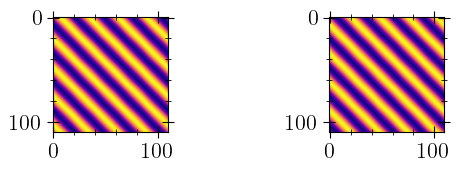

In [605]:
figure(figsize=(6, 2))
subplot(121)
# imshow(real(b1_dag_b1_minus_b1_b1_dag), cmap="plasma")
imshow(real(full_square(unskewed_b1_dag_b1) |> transpose), cmap="plasma")

subplot(122)
imshow(real(full_square(unskewed_b1_dag_b1)), cmap="plasma")

tight_layout()

In [14]:
destroyers = [b1, b2, a1, a2]
for k in 1:2L
    create_destroy[k] = two_time_average(destroyers[k].dag(), destroyers[k])
    destroy_create[k] = two_time_average(destroyers[k], destroyers[k].dag())
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [15]:
unskewed_b1_dag_b1 = create_destroy[1]
unskewed_b1_b1_dag = destroy_create[1]
# unskewed_b1_dag_b1_minus_b1_b1_dag = (unskewed_b1_dag_b1 .- unskewed_b1_b1_dag) #unskewed_b1_dag_b1_minus_b1_b1_dag[:, 1:n+1];

In [104]:
full_square = A -> (A - adjoint(A) - (A |> diag |> diagm)) 

# unskewed_b1_dag_b1 = full_square(unskewed_b1_dag_b1)
# unskewed_b1_b1_dag = full_square(unskewed_b1_b1_dag)
# unskewed_b1_dag_b1_minus_b1_b1_dag = full_square(unskewed_b1_dag_b1_minus_b1_b1_dag);

## Plotting

In [17]:
T = sol.t[end]
t_scale = 1#J
ω_scale = 1#1/J;

### Equal-time

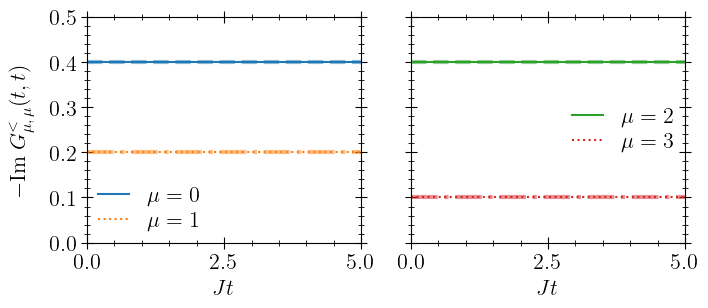

In [546]:
xpad = 8
ypad = 5

figure(figsize=(7, 3))

ax = subplot(121)
idx = 1
ax.plot(state.t, problem.GL.data[idx, idx ,:,:] |> ((-) ∘ imag ∘ diag), ls="-", label="\$\\mu="*string(idx - 1)*"\$", c="C0")
ax.plot(times, me.expect[idx], "--", c="C0", lw=3, alpha=0.5)
idx = 2
ax.plot(state.t, problem.GL.data[idx, idx ,:,:] |> ((-) ∘ imag ∘ diag), ls=":", label="\$\\mu="*string(idx - 1)*"\$", c="C1")
ax.plot(times, me.expect[idx], "-.", c="C1", lw=3, alpha=0.5)
ax.set_xlabel("\$Jt\$") 
ylabel("\$-\\mathrm{Im}\\; G^<_{\\mu,\\, \\mu}(t, t)\$", labelpad=10)
ax.set_xticks([0, 2.5, 5])
ax.set_xlim(0, state.t[end]) 
ax.set_ylim(0, 0.5)
ax.legend(loc="best", handlelength=1.4, frameon=false, borderpad=0, labelspacing=0.25)

ax = subplot(122)
idx = 3
ax.plot(state.t, problem.GL.data[idx, idx ,:,:] |> ((-) ∘ imag ∘ diag), ls="-", label="\$\\mu="*string(idx - 1)*"\$", c="C2")
ax.plot(times, me.expect[idx], "--", c="C2", lw=3, alpha=0.5)
idx = 4
ax.plot(state.t, problem.GL.data[idx, idx ,:,:] |> ((-) ∘ imag ∘ diag), ls=":", label="\$\\mu="*string(idx - 1)*"\$", c="C3")
ax.plot(times, me.expect[idx], "-.", c="C3", lw=3, alpha=0.5)
ax.set_xlabel("\$Jt\$") 
# ylabel("\$-\\mathrm{Im}\\; G^<_{ii}(t, t)\$")
ax.set_xticks([0, 2.5, 5])
ax.set_yticklabels([])
ax.set_xlim(0, state.t[end]) 
ax.set_ylim(0, 0.5)
# ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax.legend(loc="best", handlelength=1.4, frameon=false, borderpad=0, labelspacing=0.25)
tight_layout(pad=0.25, w_pad=1, h_pad=0)
# savefig("interacting_bosons_example_T.pdf")

### Relative-time

In [92]:
idx = 2;

In [105]:
ρ_11_kb = interpolate((sol.t, sol.t), view(problem.GL.data .- 0*problem.GG.data, idx, idx, :, : ), Gridded(Linear()));
# ρ_11_qt = interpolate((times, times), view(unskewed_b1_dag_b1 - unskewed_b1_b1_dag, :, : ), Gridded(Linear()));
# interpolate((times, times), view(full_square(unskewed_b1_dag_b1_minus_b1_b1_dag), :, : ), Gridded(Linear()));
ρ_11_qt = full_square(create_destroy[idx]); # unskewed_b1_dag_b1_minus_b1_b1_dag

In [111]:
ρ_11_kb = interpolate((sol.t, sol.t), view(problem.GG.data, idx, idx, :, : ), Gridded(Linear()));
ρ_11_qt = full_square(destroy_create[idx]);

In [112]:
ρ_11_kb_wigner, _ = wigner_transform([ρ_11_kb(t1, t2) for t1 in times, t2 in times]; ts=times, fourier=false);
ρ_11_kb_wigner = ρ_11_kb_wigner

ρ_11_qt_wigner, (taus, ts) = wigner_transform([ρ_11_qt[t1, t2] for t1 in 1:n+1, t2 in 1:n+1]; ts=times, fourier=false);
ρ_11_qt_wigner = ρ_11_qt_wigner;

In [113]:
ρ_11_kb_FFT, (ωs, ts) = wigner_transform([ρ_11_kb(t1, t2) for t1 in times, t2 in times]; ts=times, fourier=true);
ρ_11_kb_FFT = -ρ_11_kb_FFT

ρ_11_qt_FFT, (ωs, ts) = wigner_transform([ρ_11_qt[t1, t2] for t1 in 1:n+1, t2 in 1:n+1]; ts=times, fourier=true);
ρ_11_qt_FFT = -ρ_11_qt_FFT;

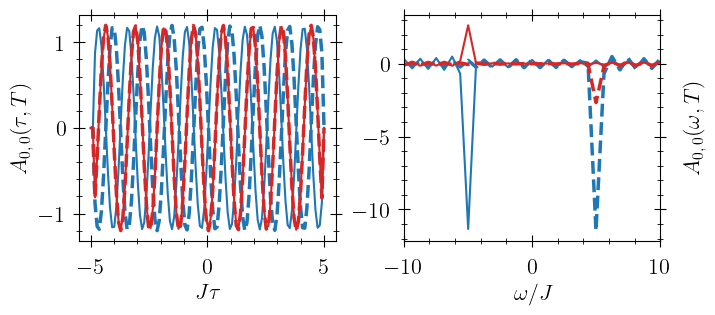

In [114]:
xpad = 8
ypad = 5

figure(figsize=(7, 3))

ax = subplot(121)
plot(t_scale * taus, ρ_11_kb_wigner[:, Int(floor(n/2))] |> real, ls="-", c="C0", lw=1.5)
plot(t_scale * taus, ρ_11_qt_wigner[:, Int(floor(n/2))] |> real, ls="--", c="C0", lw=2.5)
plot(t_scale * taus, ρ_11_kb_wigner[:, Int(floor(n/2))] |> imag, ls="-", c="C3", lw=1.5)
plot(t_scale * taus, ρ_11_qt_wigner[:, Int(floor(n/2))] |> imag, ls="--", c="C3", lw=2.5)
ax.set_xlabel("\$J \\tau\$")
# ax.set_xlim(-t_scale * T, t_scale * T)
# ax.set_ylim(-1.0, 1.0)
# ax.set_xticks(t_scale .* [-T/2, -T/4, 0, T/4, T/2])
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_ylabel("\$A_{0,\\, 0}(\\tau, T)\$")

ax = subplot(122)
plot(ω_scale * ωs, ρ_11_kb_FFT[:, Int(floor(n/2))] |> real, ls="-", c="C0", lw=1.5)
plot(ω_scale * ωs, ρ_11_qt_FFT[:, Int(floor(n/2))] |> real, ls="--", c="C0", lw=2.5)
plot(ω_scale * ωs, ρ_11_kb_FFT[:, Int(floor(n/2))] |> imag, ls="-", c="C3", lw=1.5)
plot(ω_scale * ωs, ρ_11_qt_FFT[:, Int(floor(n/2))] |> imag, ls="--", c="C3", lw=2.5)
ax.set_xlabel("\$\\omega/J\$")
ax.set_xlim(10 .* (-1, 1))
# ax.set_ylim(0, 6.0)
# ax.set_xticks([x for x in -10:5:10])
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_ylabel("\$A_{0,\\, 0}(\\omega, T)\$", labelpad=16)
ax.yaxis.set_label_position("right")
# ax.legend(loc="best", handlelength=1.4, frameon=false, borderpad=0, labelspacing=0.25)

tight_layout(pad=0.1, w_pad=0.5, h_pad=0)

# savefig("interacting_bosons_example_tau_omega.pdf")

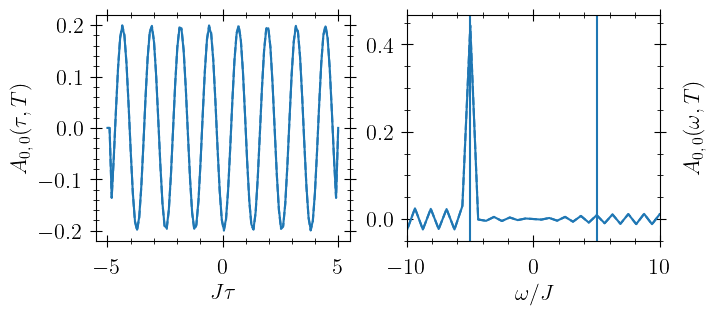

In [109]:
xpad = 8
ypad = 5

figure(figsize=(7, 3))

ax = subplot(121)
plot(t_scale * taus, ρ_11_kb_wigner[:, Int(floor(n/2))] |> imag, ls="-", c="C0", lw=1.5)
plot(t_scale * taus, ρ_11_qt_wigner[:, Int(floor(n/2))] |> imag, ls="--", c="C0", lw=1.5)
ax.set_xlabel("\$J \\tau\$")
# ax.set_xlim(-t_scale * T, t_scale * T)
# ax.set_ylim(-1.0, 1.0)
# ax.set_xticks(t_scale .* [-T/2, -T/4, 0, T/4, T/2])
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_ylabel("\$A_{0,\\, 0}(\\tau, T)\$")

ax = subplot(122)
plot(ω_scale * ωs, ρ_11_kb_FFT[:, Int(floor(n/2))] |> imag, ls="-", c="C0", lw=1.5)
plot(ω_scale * ωs, ρ_11_qt_FFT[:, Int(floor(n/2))] |> imag, ls="--", c="C0", lw=1.5)
ax.set_xlabel("\$\\omega/J\$")
ax.set_xlim(10 .* (-1, 1))
# ax.set_ylim(0, 6.0)
# ax.set_xticks([x for x in -10:5:10])
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
axvline.([-5, 5])
ax.set_ylabel("\$A_{0,\\, 0}(\\omega, T)\$", labelpad=16)
ax.yaxis.set_label_position("right")
# ax.legend(loc="best", handlelength=1.4, frameon=false, borderpad=0, labelspacing=0.25)

tight_layout(pad=0.1, w_pad=0.5, h_pad=0)

# savefig("interacting_bosons_example_tau_omega.pdf")

## Testing

In [553]:
cmap = "gist_heat"
Y, X = np.meshgrid(sol.t[1:end], sol.t[1:end]);

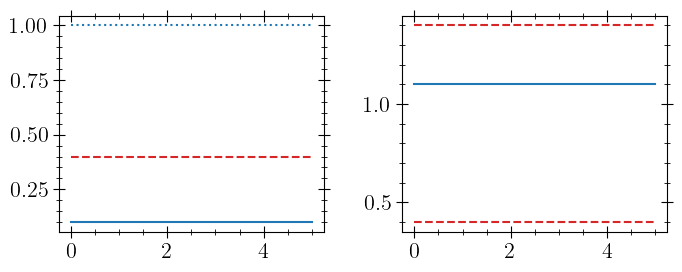

In [554]:
figure(figsize=(7, 3))

ax = subplot(121)
plot(t_scale .* times, full_square(unskewed_b1_dag_b1) |> diag |> (-) |> imag, "-C0", lw=1.5)
plot(t_scale .* times, (unskewed_b1_b1_dag - unskewed_b1_dag_b1) |> diag |> (-) |> imag, ":C0", lw=1.5)
plot(t_scale .* times, me.expect[1], "--C3", lw=1.5)
# plot(t_scale .* times, me.expect[end] - me.expect[1], ":C7", lw=1.5)

ax = subplot(122)
plot(t_scale .* times, full_square(unskewed_b1_b1_dag) |> diag |> (-) |> imag, "-C0", lw=1.5)

plot(t_scale .* times, me.expect[1], "--C3", lw=1.5)
plot(t_scale .* times, me.expect[end], "--C3", lw=1.5)

tight_layout()

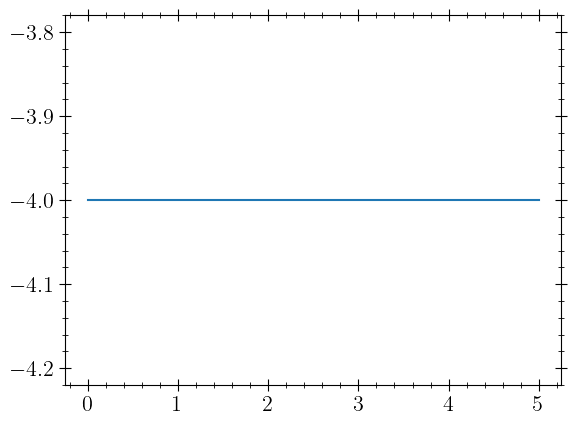

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9da5619d60>

In [555]:
plot(state.t, sum([problem.GL.data[k, k ,:,:] - problem.GG.data[k, k ,:,:] |> ((-) ∘ imag ∘ diag) for k in 1:4]))

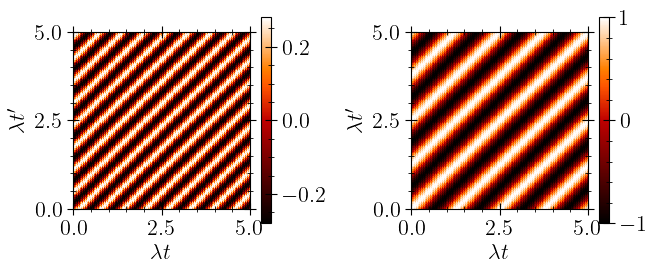

In [556]:
xpad = 8
ypad = 5

figure(figsize=(7, 3))

ax = subplot(121)
vmin = -0.5 # minimum(ρ_11)
vmax = 1.0 # maximum(ρ_11)
# ax = plt.gca()
heatmap = ax.pcolormesh(t_scale * X, t_scale * Y, -problem.GL.data[2, 2, :, :] .* problem.GG.data[1, 1, :, :] |> imag, cmap=cmap, rasterized=true)#, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
colorbar(mappable=heatmap)
ax.set_xlabel("\$\\lambda t\$")
ax.set_ylabel("\$\\lambda t'\$")
ax.set_xlim(0, t_scale * T)
ax.set_ylim(0, t_scale * T)
ax.set_xticks(t_scale .* [0, T/2, T])
ax.set_yticks(t_scale .* [0, T/2, T])


ax = subplot(122)
vmin = -0.5 # minimum(ρ_11)
vmax = 1.0 # maximum(ρ_11)
# ax = plt.gca()
heatmap = ax.pcolormesh(t_scale * X, t_scale * Y, (problem.GL.data[1, 1, :, :] - problem.GG.data[1, 1, :, :]) |> imag, cmap=cmap, rasterized=true)#, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
colorbar(mappable=heatmap)
ax.set_xlabel("\$\\lambda t\$")
ax.set_ylabel("\$\\lambda t'\$")
ax.set_xlim(0, t_scale * T)
ax.set_ylim(0, t_scale * T)
ax.set_xticks(t_scale .* [0, T/2, T])
ax.set_yticks(t_scale .* [0, T/2, T])

tight_layout()

In [557]:
test_kb = interpolate((sol.t, sol.t), view(-problem.GL.data[3, 3, :, :] .* problem.GG.data[1, 1, :, :], :, :), Gridded(Linear()));
# test_kb = interpolate((sol.t, sol.t), view(-problem.GL.data, 2, 2, :, :), Gridded(Linear()));
test_kb_wigner, (test_taus, test_ts) = wigner_transform([test_kb(t1, t2) for t1 in times, t2 in times]; ts=times, fourier=false);
test_kb_wigner = test_kb_wigner |> imag;

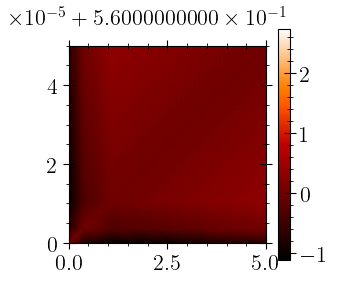

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9da31ffdf0>

In [558]:
figure(figsize=(7, 3))

ax = subplot(121)
vmin = -0.5 # minimum(ρ_11)
vmax = 1.0 # maximum(ρ_11)
# ax = plt.gca()
heatmap = ax.pcolormesh(t_scale * X, t_scale * Y, test_kb(times, times) |> real, cmap=cmap, rasterized=true)#, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
colorbar(mappable=heatmap)